In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from operations import Add, Subtract, Multiply, Divide, Power

In [2]:
class Number(object):
    def __repr__(self):
        return "Number({})".format(self.data)

    def __init__(self, obj, *, creator=None):
        assert isinstance(obj, (Number, int, float, np.generic))
        self.data = obj.data if isinstance(obj, Number) else obj
        self._creator = creator
        self.grad = None

    @property
    def creator(self):
        return self._creator
    
    @staticmethod
    def _op(Op, a, b):
        if not isinstance(a, Number):
            a = Number(a)
        if not isinstance(b, Number):
            b = Number(b)
            
        f = Op()
        result = f(a, b)
        return Number(result, creator=f)

    def __add__(self, other):
        return self._op(Add, self, other)

    def __radd__(self, other):
        return self._op(Add, other, self)

    def __mul__(self, other):
        return self._op(Multiply, self, other)

    def __rmul__(self, other):
        return self._op(Multiply, other, self)

    def __truediv__(self, other):
        return self._op(Divide, self, other)

    def __rtruediv__(self, other):
        return self._op(Divide, other, self)

    def __sub__(self, other):
        return self._op(Subtract, self, other)

    def __rsub__(self, other):
        return self._op(Subtract, other, self)

    def __pow__(self, other):
        return self._op(Power, self, other)

    def __rpow__(self, other):
        return self._op(Power, other, self)

    def __neg__(self):
        return -1*self
    
    def __eq__(self, value):
        if isinstance(value, Number):
            value = value.data
        return self.data == value

    def backprop(self, grad=1):
        if self.grad is None:
            self.grad = grad
        else:
            self.grad += grad
        
        if self._creator is not None:
            self._creator.backprop(grad = grad)
    
    def null_gradients(self):
        self.grad = None
        if self._creator is not None:
            self._creator.null_gradients()


In [3]:
data = {
    'Box Office Sales': [85.1, 106.3, 50.2, 130.6, 54.8, 30.3, 79.4, 91.0, 135.4, 89.3],
    'Production Costs': [8.5, 12.9, 5.2, 10.7, 3.1, 3.5, 9.2, 9.0, 15.1, 10.2],
    'Promotion Costs': [5.1, 5.8, 2.1, 8.4, 2.9, 1.2, 3.7, 7.6, 7.7, 4.5],
    'Book Sales': [4.7, 8.8, 15.1, 12.2, 10.6, 3.5, 9.7, 5.9, 20.8, 7.9]
}

# The following line will create a list of data points. It does this by:
# (1) creating a list containing each of the lists in `data`
# (2) unpacking the lists from (1) and passing them into `zip`
# (3) using `zip` to wrap the elements from each list together in tuples
# (4) using the elements output from `zip` to create a list
data_set = list(zip(*[data[key] for key in data]))

In [4]:
data_set # display the dataset to see it is a list of data points

[(85.1, 8.5, 5.1, 4.7),
 (106.3, 12.9, 5.8, 8.8),
 (50.2, 5.2, 2.1, 15.1),
 (130.6, 10.7, 8.4, 12.2),
 (54.8, 3.1, 2.9, 10.6),
 (30.3, 3.5, 1.2, 3.5),
 (79.4, 9.2, 3.7, 9.7),
 (91.0, 9.0, 7.6, 5.9),
 (135.4, 15.1, 7.7, 20.8),
 (89.3, 10.2, 4.5, 7.9)]

In [5]:
def l2_loss(truth, model):
    l = truth[0] - model[0] - sum(truth[i]*model[i] for i in range(1, len(model)))
    return l**2 if l.data > 0 else (-1*l)**2

In [6]:
def create_model(num_params):
    return tuple(Number(np.random.rand()) for _ in range(num_params))

In [7]:
def train_epoch(model, data_set, loss_fn, lr=0.001):
    # compute the mean error over the dataset
    mean_loss = sum(loss_fn(sample, model) for sample in data_set) / len(data_set)
    
    # compute gradients for our parameters
    mean_loss.null_gradients()
    mean_loss.backprop()
    
    # update the model parameters using gradient descent
    for param in model:
        # recall: param.grad is d(L)/d(param)
        # thus this computes:
        # param_new = param_old - step-size * d(L)/d(param) 
        param.data -= lr*param.grad  
        
    # return the loss for visualization
    return mean_loss.data

In [8]:
model = create_model(4)
losses = []
for _ in range(1000):
    losses.append(train_epoch(model, data_set, l2_loss))

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

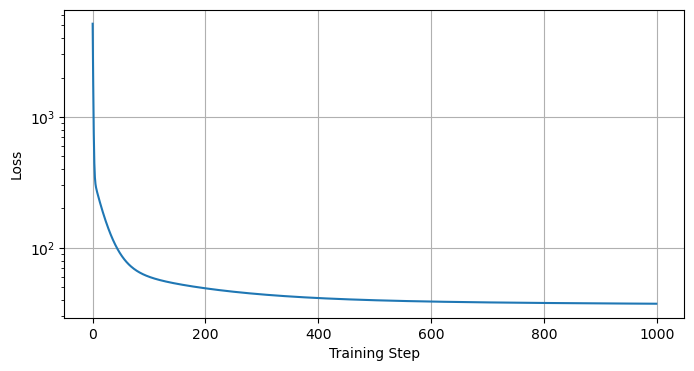

In [10]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(losses)
ax.set_yscale('log')
ax.set_ylabel('Loss')
ax.set_xlabel('Training Step');
ax.grid(True)

In [11]:
def l1_loss(truth, model):
    l = truth[0] - model[0] - sum(truth[i]*model[i] for i in range(1, len(model)))
    return l if l.data > 0 else (-1*l)**2

In [12]:
model = create_model(4)
losses = []
for _ in range(1000):
    the_loss = train_epoch(model, data_set, l1_loss)
    losses.append(the_loss)

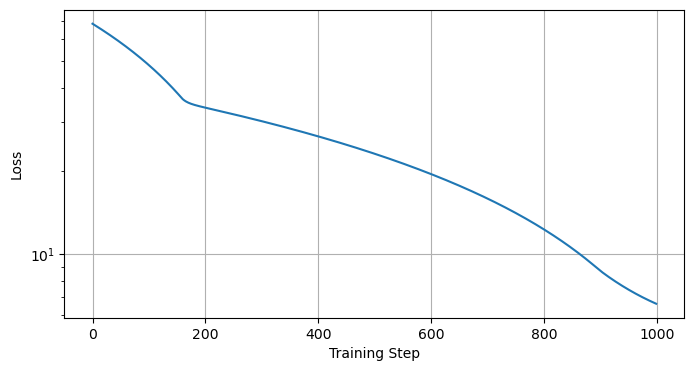

In [13]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(losses)
ax.set_yscale('log')
ax.set_ylabel('Loss')
ax.set_xlabel('Training Step');
ax.grid(True)

In [14]:
data = {
    'Box Office Sales': [85.1, 106.3, 50.2, 130.6, 54.8, 30.3, 79.4, 91.0, 135.4, 89.3],
    'Production Costs': [8.5, 12.9, 5.2, 10.7, 3.1, 3.5, 9.2, 9.0, 15.1, 10.2],
    'Promotion Costs': [5.1, 5.8, 2.1, 8.4, 2.9, 1.2, 3.7, 7.6, 7.7, 4.5],
    'Book Sales': [4.7, 8.8, 15.1, 12.2, 10.6, 3.5, 9.7, 5.9, 20.8, 7.9],
    'Random1': [np.random.rand() for _ in range(10)],
    'Random2': [np.random.rand() for _ in range(10)],
    'Random3': [np.random.rand() for _ in range(10)]
}

data_set = list(zip(*[data[key] for key in data]))

In [15]:
model = create_model(7)
losses = []
for _ in range(1000):
    the_loss = train_epoch(model, data_set, l2_loss)
    losses.append(the_loss)

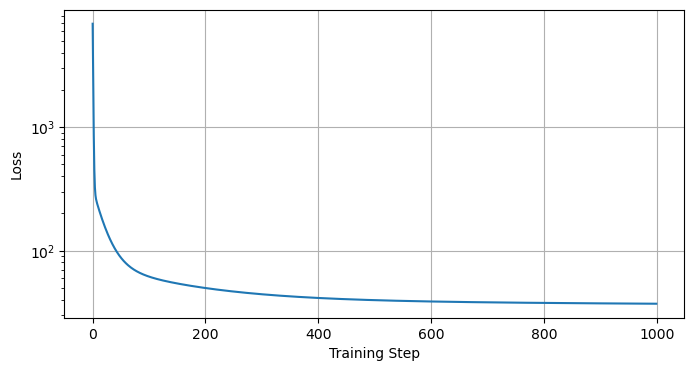

In [16]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(losses)
ax.set_yscale('log')
ax.set_ylabel('Loss')
ax.set_xlabel('Training Step');
ax.grid(True)

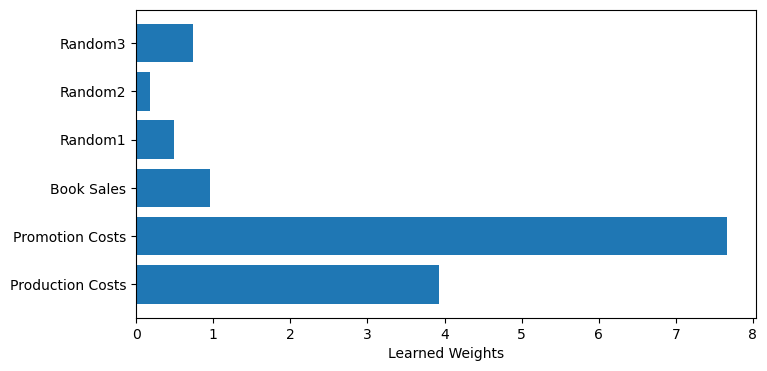

In [17]:
# Execute this cell to visualize what weighting your model learned
fig, ax = plt.subplots(figsize=(8,4))
ax.barh(np.arange(6), [model[i].data for i in range(1, len(model))])
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.set_yticklabels(['Production Costs', 'Promotion Costs', 'Book Sales', 'Random1',
                    'Random2', 'Random3'])
ax.set_xlabel('Learned Weights');